### Ensamble de primer y séptimo modelo.
### Me interesa por ver cómo se comporta juntando dos procesados de datos.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Exportar modelos
import pickle

# Pipeline
from sklearn.pipeline import Pipeline

# CV
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
# Cargamos datos
data = pd.read_csv('../data/processed/primer_procesado_entrenamiento.csv', sep = '\t')
target = pd.read_csv('../data/processed/primer_procesado_target.csv', sep = '\t')

In [53]:
# Cambiamos los nombres de las features para que no contengan espacios ni caracteres especiales
data.columns = ['pressure', 'mass_flux', 'x_e_out', 'D_e', 'D_h', 'length', 'chf_exp']


In [54]:
# Dividimos en features y target, siendo el target x_e_out [-]
X = data.drop(['x_e_out'], axis = 1)
y = data['x_e_out']
# Luego tendremos que recuperar los nombres originales de las features

In [55]:
# Dividimos entre train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)


In [7]:
# # Escalamos los datos
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [56]:
# Cargamos los modelos
modelo1 = pickle.load(open('../output/models/primer_procesado_primer_modelo_xgboost.pickle', 'rb'))
modelo2 = pickle.load(open('../output/models/quinto_procesado_LGBM.pickle', 'rb'))
from sklearn.ensemble import VotingRegressor
ensemble = VotingRegressor(estimators=[('xgb', modelo1), ('lgbmr', modelo2)], weights=[0.5, 1])


In [57]:
# Entrenamos el modelo
ensemble.fit(X_train, y_train)
preds_test = ensemble.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, preds_test)))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Test RMSE: 0.07589225308853616


In [58]:
cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force

In [59]:
metricas = -cv_scores
media_metricas = metricas.mean()
# Imprime las métricas de evaluación en validación cruzada
print('Métricas en validación cruzada:')
print(metricas)
print('Media de las métricas:', media_metricas)

Métricas en validación cruzada:
[0.00566603 0.00543221 0.00555524 0.00504622 0.00561913]
Media de las métricas: 0.005463764163725835


In [60]:
# Predecir los valores de salida para los datos de prueba utilizando el mejor modelo
y_pred = ensemble.predict(X_test)

In [61]:
# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Error cuadrático medio:', mse)
print('Raíz del error cuadrático medio:', np.sqrt(mse))
print('Error absoluto medio:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))


Error cuadrático medio: 0.005759634078854425
Raíz del error cuadrático medio: 0.07589225308853616
Error absoluto medio: 0.05164620628167308
R2: 0.4611305389403374


### Extraemos todas las métricas para este modelo en formato csv

In [62]:
# Crea un pd.DataFrame con las métricas de evaluación
df_metricas = pd.DataFrame({'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}, index=[0])
df_metricas

,MSE,RMSE,MAE,R2
0,0.00576,0.075892,0.051646,0.461131


In [63]:
# Extraemos todas las métricas de evaluación del modelo en formato dataframe y luego lo pasamos a csv
metricas_ensemble = pd.DataFrame({'MSE' : [mse], 'RMSE' : [rmse], 'MAE' : [mae], 'R2' : [r2]})


### Gráficas de resultados

In [72]:
# Extraemos la feature importance del best model
feature_importance = ensemble.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
feature_names = X.columns
feature_names = feature_names[sorted_idx]
feature_importance = feature_importance[sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5

# Representamos la importancia de las features
plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feature_names)
plt.xlabel('Importancia relativa')
plt.title('Importancia de las features')
plt.show()


AttributeError: 'VotingRegressor' object has no attribute 'feature_importances_'

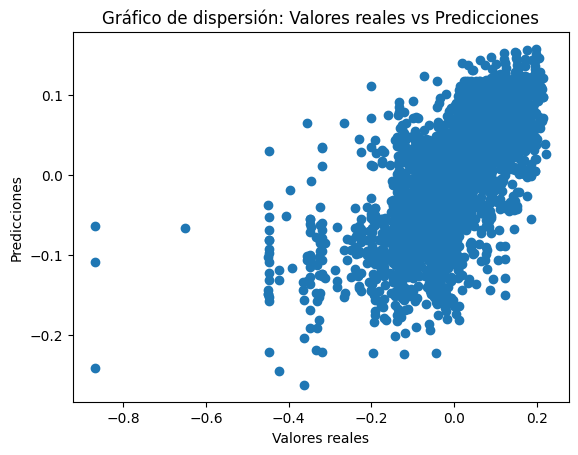

In [64]:
import matplotlib.pyplot as plt

# Obtén las predicciones del modelo


# Traza el gráfico de dispersión
plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de dispersión: Valores reales vs Predicciones')
plt.show()


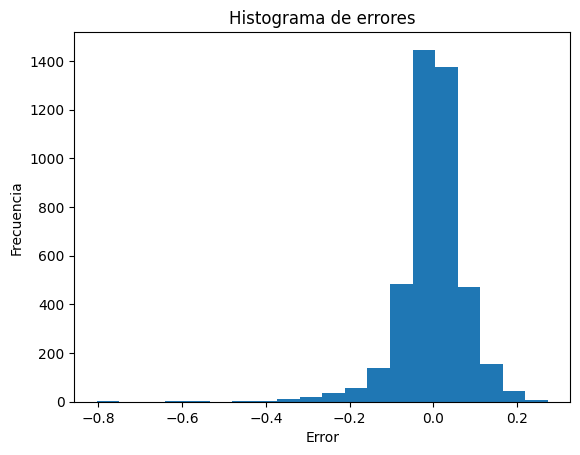

In [65]:
import numpy as np

# Calcula los errores
errores = y_test - y_pred

# Traza el histograma de errores
plt.hist(errores, bins=20)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores')
plt.show()

In [66]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Entrenamiento')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Prueba')
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1, color='r'
    )
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color='g'
    )
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Pérdida')
    plt.title('Curva de aprendizaje')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

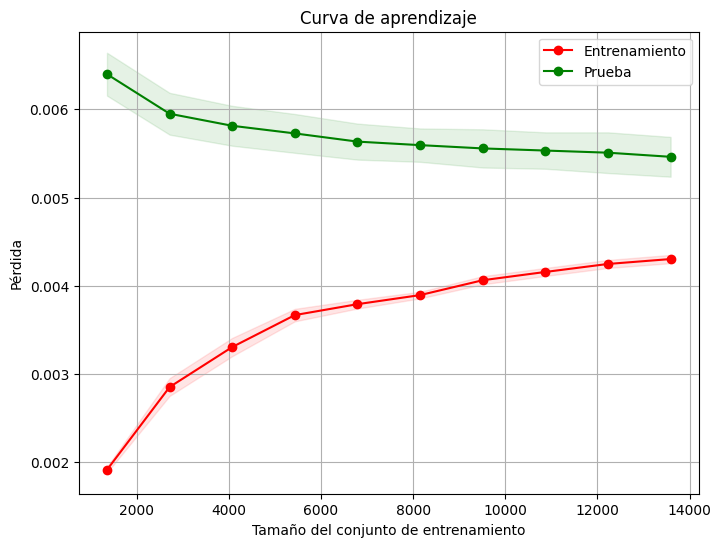

In [67]:
plot_learning_curve(ensemble, X_train, y_train, cv=5)

### Guardamos el modelo en un archivo .pickle
#### (Pendiente de hacer función)

In [69]:
nombre_archivo = '../output/models/ensemble_XGBoost1_LGBMR5.pickle'
modelo = ensemble
import pickle
try:
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(modelo, archivo)
    print(f"El modelo se ha guardado exitosamente en {nombre_archivo}.")
except IOError:
    print("Error: No se pudo guardar el modelo. Permiso denegado.")

El modelo se ha guardado exitosamente en ../output/models/ensemble_XGBoost1_LGBMR5.pickle.


In [70]:
def csv_datos(nombre_archivo, data):
    '''Guarda el dataframe data en un archivo csv con nombre nombre_archivo
    en la carpeta data/processed'''
    ruta_archivo = '../output/reports'
    data.to_csv(ruta_archivo + "/" + nombre_archivo, sep='\t', index=False)

In [71]:
# Guardamos los datos con las métricas en un csv
ruta_archivo = '../output/reports/'
csv_datos("metricas_ensemble.csv", metricas_ensemble)